In [3]:
import pandas as pd
import sys

from scipy.optimize import minimize
from scipy.stats import norm, uniform, binom
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal

%run tools.py

## Bayesian linear modeling

Now that we explored in detail the population height, we can finally start our studying on the relationship between weight and height.

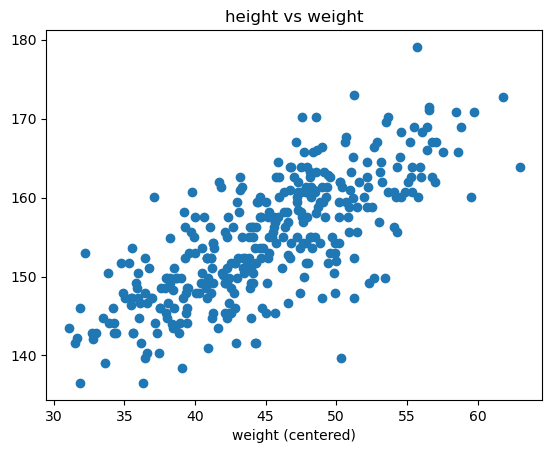

In [4]:
data = pd.read_csv('Howell1.csv', sep = ';')
data1 = data[data.age>=18]

plt.scatter(data1.weight, data1.height)
plt.title('height vs weight')
plt.xlabel('height (cm)')
plt.xlabel('weight (centered)')
plt.show()

In [5]:
data1

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
534  162.560  47.031821  27.0     0
537  142.875  34.246196  31.0     0
540  162.560  52.163080  31.0     1
541  156.210  54.062497  21.0     0
543  158.750  52.531624  68.0     1

[352 rows x 4 columns]

The dataset *Howell* contains partial census data for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s.

At this point we need to increase a bit the complexity of out Bayesian model, as we are now performing a *regression*.
In particular, we are interested in the relationship:

$$\mbox{height} = a + b * \mbox{weight},$$

and we would like to obtain posterior distributions for the regression coefficients $a$ and $b$. As in classical regression models, the variable $a$ is called *intercept*, and expresses the age we expect when the weight is 0, and $b$ is the *slope*, which indicates how much the height changes for a unit increase of weight.

To proceed with our Bayesian treatment, the trick here is to assume that our previous Gaussian model of height is indeed dependent on the variable weight through this linear relationship. In this case, the height of an individual $i$ is a sample from a Gaussian model:

$$\mbox{height}_i\sim N(\mu_i,\sigma^2),$$

whiel this time we impose that $\mu_i = a + b * \mbox{weight}_i$. Note that while we allow the mean $\mu_i$ to vary depending on the weight, the coefficients $a$ and $b$, as well as the noise $\sigma$ are the same across subjects.  
To completely define our Bayesian model, we need to specify priors for all the parameters we want to analyze:

$$ p(a) = N(178, 1000),$$

$$ p(b) = N(0, 100),$$

$$ p(\sigma) = U(0, 50).$$

We code all these elements to run our black-box machine:

In [6]:
expr = 'height ~   weight'    # y =a+bx   regression relationship

# Initializing the likelihood
likelihood = 'gaussian'








# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

And we are finally ready to perform inference:


In [7]:
solution_regression = laplace_solution_regression(expr, data1, likelihood, priors)


C:\Users\praba\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1083.8791047601253
        x: [ 1.139e+02  9.045e-01  5.072e+00]
      nit: 48
      jac: [ 0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[ 4.829e-01 -9.804e-03 -3.559e-02]
            [-9.804e-03  2.360e-04  7.429e-04]
            [-3.559e-02  7.429e-04  3.067e-02]]
     nfev: 250
     njev: 62


As before, we can sample from our posterior to explore the distribution of our model parameters: 

In [8]:
solution_regression

[array([113.90340656,   0.90450579,   5.07186731]),
 array([[ 4.82873274e-01, -9.80415677e-03, -3.55944422e-02],
        [-9.80415677e-03,  2.36025332e-04,  7.42945239e-04],
        [-3.55944422e-02,  7.42945239e-04,  3.06689594e-02]])]

In [9]:
posterior_samples = multivariate_normal.rvs(solution_regression[0], solution_regression[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary = pd.DataFrame(summary_stats).transpose()
summary.columns = ['mean', 'SD', '7.5%', '92.5%']
summary.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary)

             mean        SD        7.5%       92.5%
a      113.888206  0.700177  112.876407  114.845670
b        0.904445  0.015474    0.882199    0.926447
sigma    5.068684  0.169817    4.816842    5.309630


In [10]:
posterior_samples

array([[114.26349471,   0.89340362,   4.87795706],
       [113.23236146,   0.92379955,   4.87613087],
       [112.65420401,   0.92430942,   5.36303389],
       ...,
       [113.9890973 ,   0.90282371,   5.00340293],
       [112.95322449,   0.92852662,   5.25191771],
       [113.35945777,   0.91773969,   4.89041577]])

We try to run the model again by centering the data, what is the difference in the posteriors? Can you explain this difference?

In [11]:
# Centering the data
mean_weight = np.mean(data1.weight)
data_center = data1
data_center.weight = data1.weight - mean_weight

# Fitting the model again
solution_regression_center = laplace_solution_regression(expr, data_center, likelihood, priors)

C:\Users\praba\AppData\Local\Temp\ipykernel_30228\8220345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_center.weight = data1.weight - mean_weight
C:\Users\praba\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\praba\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1083.700995967057
        x: [ 1.546e+02  9.050e-01  5.072e+00]
      nit: 24
      jac: [ 1.526e-05  1.526e-05  1.526e-05]
 hess_inv: [[ 8.871e-02  7.038e-02 -9.020e-02]
            [ 7.038e-02  6.346e-02 -7.239e-02]
            [-9.020e-02 -7.239e-02  9.258e-02]]
     nfev: 309
     njev: 73


In [12]:
solution_regression_center

[array([154.59726355,   0.90501319,   5.07186585]),
 array([[ 0.08871463,  0.07037533, -0.09019667],
        [ 0.07037533,  0.06346352, -0.07239262],
        [-0.09019667, -0.07239262,  0.09258033]])]

In [13]:
# Computing posterior samples
posterior_samples_center = multivariate_normal.rvs(solution_regression_center[0], solution_regression_center[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples_center, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples_center, axis = 0)
# mean
post_mean = np.mean(posterior_samples_center, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary_stats)

             mean        SD        7.5%       92.5%
a      154.584107  0.302115  154.148709  155.003755
b        0.894061  0.256499    0.524729    1.258747
sigma    5.084767  0.308663    4.660441    5.534743


In [49]:
posterior_samples_center.shape

(1000, 3)

Once obtained the parameters, we can start exploring the model.
Let's plot the average prediction along the entire weight range:

[154.59538035   0.90354755   5.07318051]


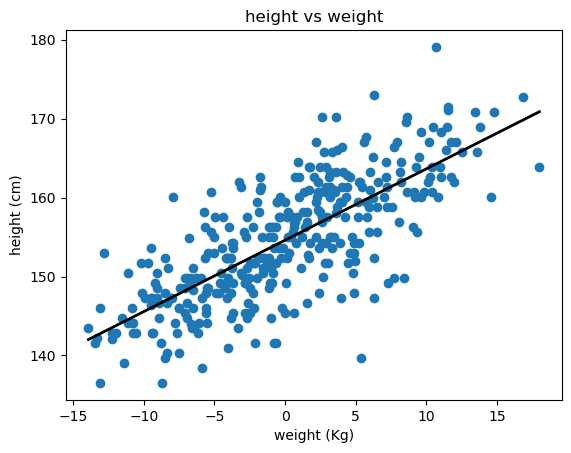

In [28]:
#plotting the results 
print(post_mean)

x_range = np.linspace(min(data_center.weight), max(data_center.weight))
mean_prediction = post_mean[0] + post_mean[1] * x_range

plt.plot(x_range, mean_prediction, lw = 2, color = 'black')
plt.scatter(data_center.weight,data_center.height)
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.show()

[154.59538035   0.90354755   5.07318051]


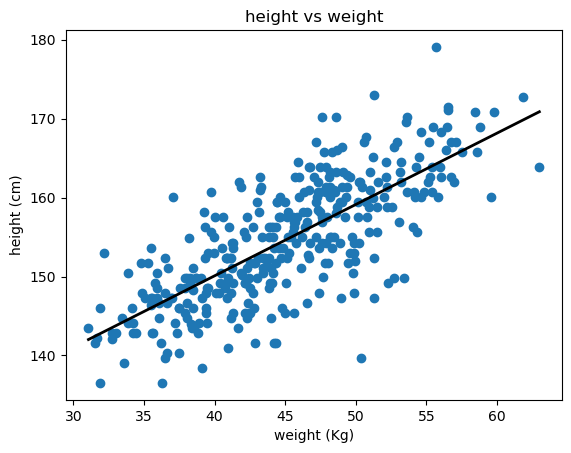

In [29]:
#plotting the average results 
print(post_mean)

x_range = np.linspace(min(data_center.weight), max(data_center.weight))
mean_prediction = post_mean[0] + post_mean[1] * x_range

plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.scatter(data_center.weight + mean_weight,data_center.height)
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.show()

Now we can explore the variability of the prediction, this can be done by using the posterior samples for the coefficients that we computed before:

In [30]:
posterior_samples_center.shape

(1000, 3)

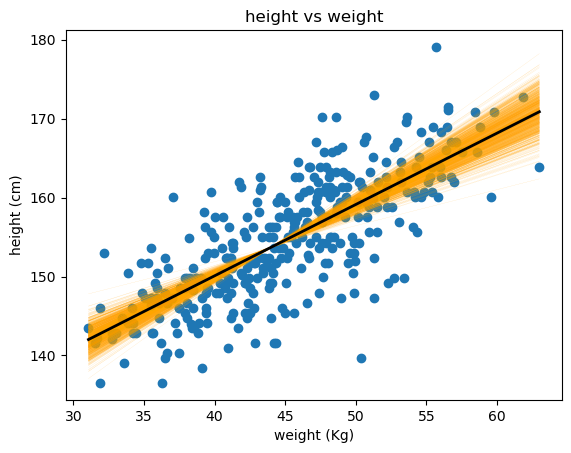

In [31]:
#sampling from the posterior

for i in range(1000):
    prediction = posterior_samples_center[i,0] + posterior_samples_center[i,1] * x_range
    plt.plot(x_range + mean_weight, prediction, lw = 0.05, color = 'orange')

plt.scatter(data_center.weight + mean_weight,data_center.height)
plt.plot(x_range + mean_weight, mean_prediction, lw = 2, color = 'black')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')


plt.show()

In [34]:
x_range

array([-13.91943352, -13.26797358, -12.61651364, -11.9650537 ,
       -11.31359376, -10.66213383, -10.01067389,  -9.35921395,
        -8.70775401,  -8.05629407,  -7.40483413,  -6.75337419,
        -6.10191425,  -5.45045432,  -4.79899438,  -4.14753444,
        -3.4960745 ,  -2.84461456,  -2.19315462,  -1.54169468,
        -0.89023474,  -0.23877481,   0.41268513,   1.06414507,
         1.71560501,   2.36706495,   3.01852489,   3.66998483,
         4.32144477,   4.9729047 ,   5.62436464,   6.27582458,
         6.92728452,   7.57874446,   8.2302044 ,   8.88166434,
         9.53312428,  10.18458421,  10.83604415,  11.48750409,
        12.13896403,  12.79042397,  13.44188391,  14.09334385,
        14.74480379,  15.39626373,  16.04772366,  16.6991836 ,
        17.35064354,  18.00210348])

By following the same modeling procedure, we can study how the uncertainty on the estimation of the coefficients varies with the different sample sizes: 

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 71.32545922184423
        x: [ 1.536e+02  8.687e-01  4.746e+00]
      nit: 28
      jac: [-9.537e-07  4.768e-06  4.768e-06]
 hess_inv: [[ 9.967e-01  1.011e-02  7.348e-02]
            [ 1.011e-02  1.687e-02 -9.040e-04]
            [ 7.348e-02 -9.040e-04  4.994e-01]]
     nfev: 124
     njev: 31


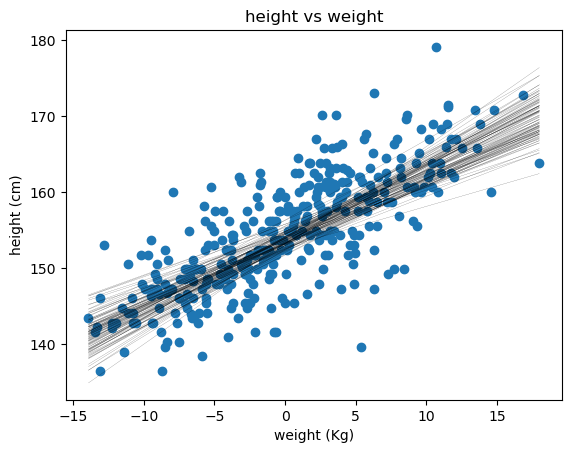

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 161.3106674785991
        x: [ 1.529e+02  8.897e-01  4.809e+00]
      nit: 13
      jac: [ 7.629e-06 -5.722e-06 -5.722e-06]
 hess_inv: [[ 4.498e-01  1.348e-03  4.108e-03]
            [ 1.348e-03  8.784e-03  5.691e-06]
            [ 4.108e-03  5.691e-06  2.310e-01]]
     nfev: 76
     njev: 19


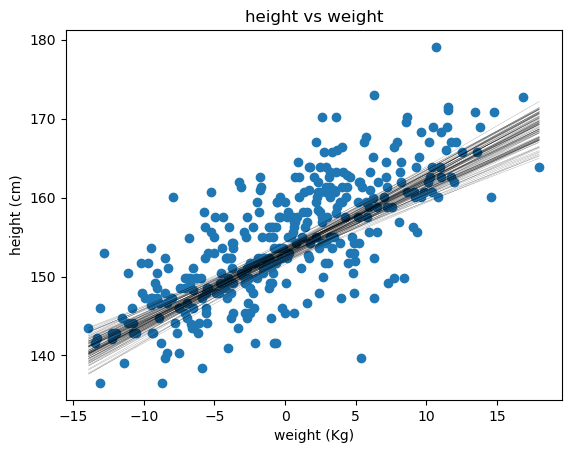

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 478.32116064090286
        x: [ 1.538e+02  9.019e-01  5.427e+00]
      nit: 19
      jac: [ 7.629e-06  3.815e-06  3.815e-06]
 hess_inv: [[ 1.742e-01 -2.882e-03 -2.192e-04]
            [-2.882e-03  4.045e-03 -6.850e-05]
            [-2.192e-04 -6.850e-05  9.581e-02]]
     nfev: 92
     njev: 23


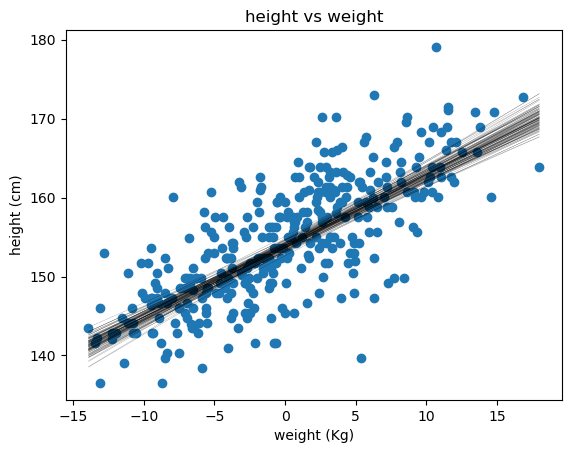

C:\Users\praba\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\praba\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1076.6635796350117
        x: [ 1.546e+02  9.106e-01  5.072e+00]
      nit: 20
      jac: [ 0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[ 3.450e-02 -9.916e-04 -1.177e-02]
            [-9.916e-04  1.903e-03 -3.066e-04]
            [-1.177e-02 -3.066e-04  3.653e-02]]
     nfev: 128
     njev: 31


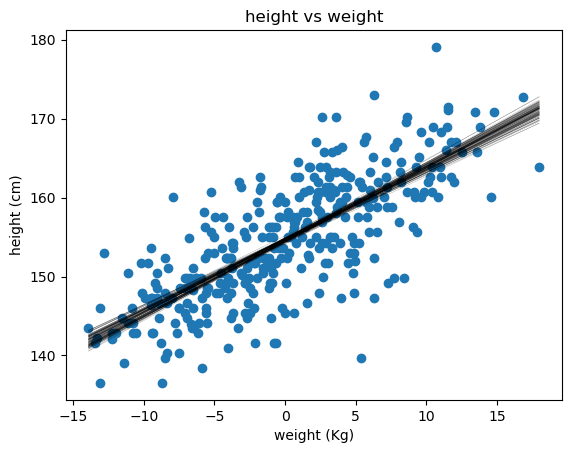

In [32]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 20
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Posterior uncertainty vs sample size

for N in [20,50,150,350]:
    
    # Selecting a subset of the data with sample size = N
    sub_data = data_center.head(N)
    # Fitting the model again
    R = laplace_solution_regression(expr, sub_data, likelihood, priors)

    # Computing posterior samples
    post_R = multivariate_normal.rvs(R[0], R[1], size = 1000)

    for i in range(100):
        prediction = post_R[i,0] + post_R[i,1] * x_range
        plt.plot(x_range, prediction, lw = 0.1, color = 'black')

    plt.scatter(data1.weight,data1.height)
    plt.title('height vs weight')
    plt.ylabel('height (cm)')
    plt.xlabel('weight (Kg)')


    plt.show()  

The model also allows us to quantify the uncertainty of the prediction for a single odata point.

**Exercise.** Predict the height distribution for a person of 50Kg.

array([157.85417488, 160.36185342])

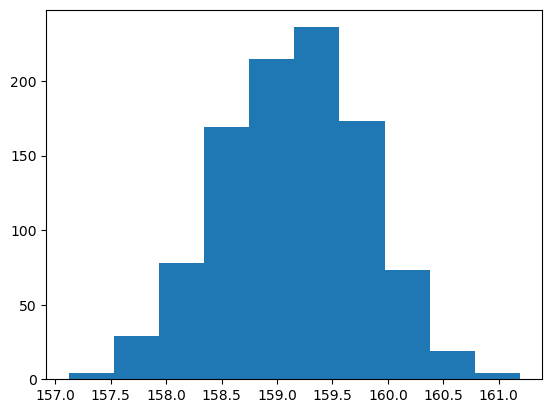

In [38]:
# Predict height for a person weighing 50 kg
test_weight = 50- mean_weight

posterior_samples_center = multivariate_normal.rvs(solution_regression_center[0], solution_regression_center[1], size = 1000)
test_pred = []

for i in range(1000):
    test_pred.append( posterior_samples_center[i,0] + posterior_samples_center[i,1] * test_weight )
    
    
    
# plt.boxplot(test_pred)
plt.hist(test_pred)
np.quantile(test_pred, [0.025,0.975])

{'whiskers': [<matplotlib.lines.Line2D at 0x1599e007510>,
 'caps': [<matplotlib.lines.Line2D at 0x1599e005650>,
 'boxes': [<matplotlib.lines.Line2D at 0x1599e17bd10>],
 'medians': [<matplotlib.lines.Line2D at 0x1599e006850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1599dcabbd0>],
 'means': []}

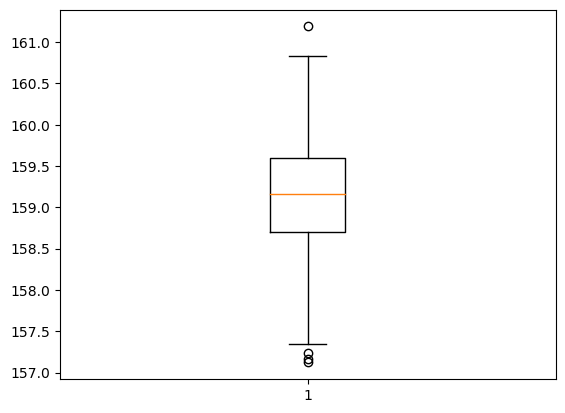

In [39]:
plt.boxplot(test_pred)


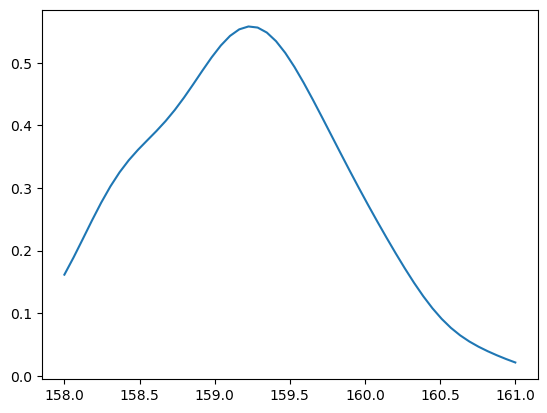

In [41]:
x = 50
x_center = x - mean_weight
prediction = []
for i in range(100):
    prediction.append(posterior_samples_center[i,0] + posterior_samples_center[i,1] * x_center)

data_density = gaussian_kde(prediction)
plt.plot(np.linspace(158,161), data_density(np.linspace(158,161)))
plt.show()

**Exercise.** Repeat the exercise for the entire range of weights:

In [42]:
range_x_test = np.linspace(30,65)
x_range_center = range_x_test - mean_weight



In [45]:
x_range_center.shape

(50,)

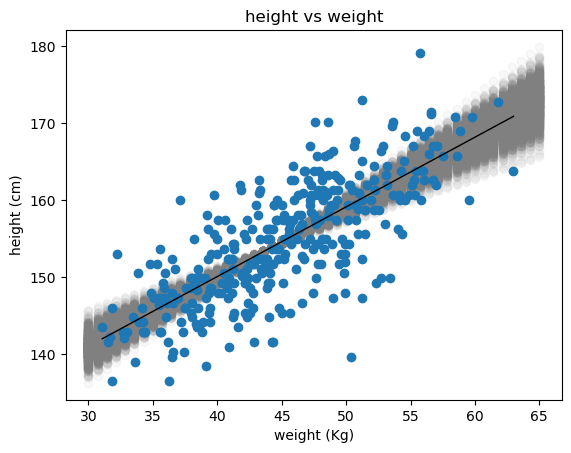

In [44]:
range_x_test = np.linspace(30,65)
x_range_center = range_x_test - mean_weight


prediction_range = []
N_s = len(posterior_samples_center[:,0])

#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range.append(posterior_samples_center[:,0] + posterior_samples_center[:,1] * x_)  

# Plotting the uncertainty
for i,x_ in enumerate(x_range_center):    
    plt.scatter(np.repeat(x_,N_s) + mean_weight, prediction_range[i], alpha = 0.05, color = 'grey')


#plotting the data
plt.scatter(data1.weight + mean_weight,data1.height)

# Plotting average prediction    
#avg_prediction = post_mean[0] + post_mean[1] * x_range_center
plt.plot(x_range + mean_weight, mean_prediction, lw = 1, color = 'black')

# Plotting +/- sigma theoretical interval
#plt.fill_between(x_range_center + mean_weight, mean_prediction - post_mean[2], mean_prediction + post_mean[2], alpha=0.1, color = 'green', linestyle='dashdot')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')

plt.show()

So far we analyzed only the uncertainty related to the mean prediction, but we see that many data points fall clearly beyond the confidence interval.  
We can estimate the overall posterior uncertainty of the prediction, while accounting for the estimated regression noise. 
This requires to sample from the data posterior, accounting for the variability for both regression coefficients and modelled noise:

In [64]:
posterior_samples_center

array([[154.504488  ,   0.93026869,   5.1197401 ],
       [154.66860883,   1.01576064,   4.98702586],
       [154.56441389,   0.90774123,   5.11781553],
       ...,
       [154.4030739 ,   0.75266194,   5.23324483],
       [154.64552079,   0.96827162,   5.03564303],
       [154.48691849,   0.75174099,   5.20685726]])

[]

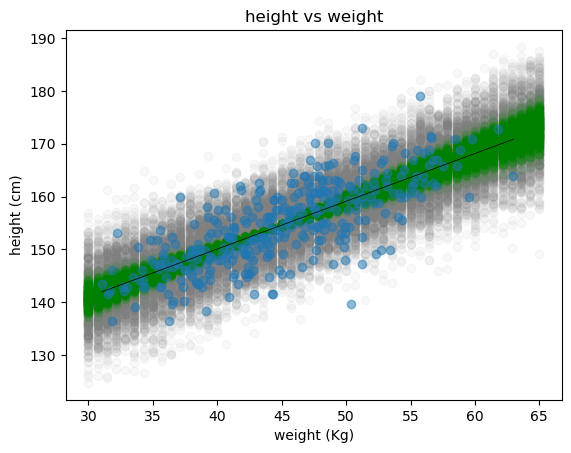

In [50]:
prediction_range = []
#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range.append(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_)  

prediction_range_noise = []

#sampling from the posterior to get a predictive interval
for x_ in (x_range_center):
    prediction_range_noise.append(norm.rvs(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_,  
                                           posterior_samples_center[:500,2]))  
    
# Plotting the uncertainty
for i,x_ in enumerate(x_range_center): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range_noise[i], alpha = 0.05, color = 'grey')
for i,x_ in enumerate(x_range_center): 
    plt.scatter(np.repeat(x_,500) + mean_weight, prediction_range[i], alpha = 0.05, color = 'green')


plt.scatter(data1.weight + mean_weight,data1.height, alpha = 0.5)
plt.plot(x_range + mean_weight, mean_prediction, lw = 0.5, color = 'black')
plt.title('height vs weight')
plt.ylabel('height (cm)')
plt.xlabel('weight (Kg)')
plt.plot()

In [60]:
posterior_samples_center.shape

(1000, 3)

In [61]:
norm.rvs(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_,  
                                           posterior_samples_center[:500,2])

array([171.58106056, 171.06294811, 177.8525698 , 175.58972425,
       178.10132344, 173.07560035, 164.88613405, 169.790047  ,
       172.23825678, 163.84421211, 173.49825534, 165.0154903 ,
       172.02396431, 176.67447396, 159.57760944, 171.51973154,
       187.42210842, 172.40104724, 173.75561083, 171.2774576 ,
       183.86931321, 170.45681836, 169.41272414, 167.59699913,
       183.08426564, 184.00324711, 180.94927172, 175.56176014,
       183.81641086, 170.6399972 , 177.94190046, 181.28148746,
       170.49845554, 166.93553761, 176.27959061, 176.48576206,
       166.52349268, 178.79723924, 171.88902316, 179.53193696,
       175.09306468, 176.49778051, 165.00314878, 177.6051219 ,
       179.47746233, 169.75792331, 177.05532731, 179.90636343,
       166.93058807, 162.60094416, 171.84465595, 172.14416561,
       179.40056241, 167.83032575, 173.22980775, 172.07579689,
       172.02410827, 162.3820012 , 172.99375167, 173.70208751,
       170.33222624, 167.46938651, 178.03679142, 181.01

In [56]:
multivariate_normal.rvs(solution_regression_center[0], solution_regression_center[1], size = 1000)


array([[154.77990556,   1.13280587,   4.88018406],
       [154.79724256,   1.12389691,   4.8631788 ],
       [154.38192072,   0.71956793,   5.32742081],
       ...,
       [154.68446173,   1.00044129,   4.97749523],
       [154.56385705,   0.84804474,   5.11431834],
       [154.40311868,   0.76662347,   5.26495049]])

In [63]:
solution_regression_center[0]

array([154.597264  ,   0.90501319,   5.07186604])

In [62]:
posterior_samples_center

array([[154.504488  ,   0.93026869,   5.1197401 ],
       [154.66860883,   1.01576064,   4.98702586],
       [154.56441389,   0.90774123,   5.11781553],
       ...,
       [154.4030739 ,   0.75266194,   5.23324483],
       [154.64552079,   0.96827162,   5.03564303],
       [154.48691849,   0.75174099,   5.20685726]])

In [55]:
norm.rvs(posterior_samples_center[:500,0] + posterior_samples_center[:500,1] * x_,  
                                           posterior_samples_center[:500,2])

array([181.54073439, 179.62840864, 166.79175469, 184.64305911,
       174.84044203, 172.22875257, 181.26173537, 169.70216848,
       176.47221304, 176.14286945, 167.84361621, 173.48563468,
       166.32320858, 171.40357553, 168.51508897, 180.79365307,
       171.69364465, 172.90184824, 179.70744805, 162.79282832,
       170.48484765, 174.81885868, 173.96401335, 173.03867961,
       167.35531995, 178.87373611, 169.20500137, 177.23313474,
       177.01193062, 180.84396641, 169.17201716, 168.50447457,
       168.9654508 , 174.65651857, 176.34897795, 167.2217503 ,
       177.70998682, 174.28122286, 181.21377459, 176.61727862,
       167.50776106, 183.49075499, 172.31512765, 169.45888892,
       176.77348327, 172.32972586, 174.07981875, 168.71867752,
       169.43115875, 180.19864172, 166.8590807 , 173.41306649,
       178.53849883, 167.85760152, 176.10114875, 178.54128736,
       175.98665558, 174.36105967, 166.66504555, 178.31392963,
       170.1869683 , 167.07845554, 182.38411049, 169.47

**Exercise.** Include the individual with age less than 18 years, and repeat the analysis. 

Which kind of model would you use for modeling this data?

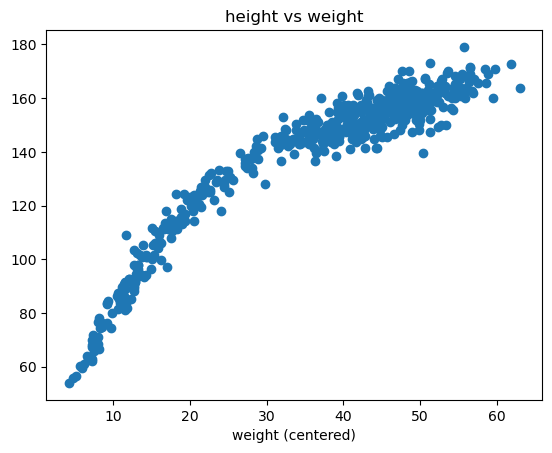

In [65]:
data = pd.read_csv('Howell1.csv', sep = ';')

plt.scatter(data.weight, data.height)
plt.title('height vs weight')
plt.xlabel('height (cm)')
plt.xlabel('weight (centered)')
plt.show()

In [67]:
expr = 'height ~   weight + weight2'    # y =a+bx   regression relationship

data['weight2'] = data.weight * data.weight 

data

height     weight   age  male      weight2
0    151.765  47.825606  63.0     1  2287.288637
1    139.700  36.485807  63.0     0  1331.214076
2    136.525  31.864838  65.0     0  1015.367901
3    156.845  53.041914  41.0     1  2813.444694
4    145.415  41.276872  51.0     0  1703.780162
..       ...        ...   ...   ...          ...
539  145.415  31.127751  17.0     1   968.936882
540  162.560  52.163080  31.0     1  2720.986915
541  156.210  54.062497  21.0     0  2922.753528
542   71.120   8.051258   0.0     1    64.822755
543  158.750  52.531624  68.0     1  2759.571468

[544 rows x 5 columns]

In [68]:

# Initializing the likelihood
likelihood = 'gaussian'








# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

In [69]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)


C:\Users\praba\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\praba\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 9853814.809261099
        x: [ 1.516e+04 -1.241e+03  1.965e+01]
      nit: 28
      jac: [-1.500e+00 -4.388e+01 -1.545e+03]
 hess_inv: [[ 1.516e+03 -1.249e+02  1.976e+00]
            [-1.249e+02  1.030e+01 -1.629e-01]
            [ 1.976e+00 -1.629e-01  2.578e-03]]
     nfev: 411
     njev: 97


In [72]:
posterior_samples = multivariate_normal.rvs(solution_regression[0], solution_regression[1], size = 1000)

# Computing summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)

summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]

summary = pd.DataFrame(summary_stats).transpose()
summary.columns = ['mean', 'SD', '7.5%', '92.5%']
summary.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary)

               mean         SD          7.5%         92.5%
a      15154.235731  37.972245  15099.477832  15212.030200
b      -1240.662300   3.134424  -1245.434672  -1236.124769
sigma     19.646419   0.049619     19.574177     19.722184


In [73]:
post_sd

array([37.97224481,  3.13442378,  0.04961851])

In [76]:
posterior_samples[5]

array([15053.00873631, -1232.42192003,    19.5174943 ])

In [79]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 20
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

